In [1]:
import os
import json
import base64
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['text.usetex'] = True

In [3]:
markers = ["p", "P", "*", "^", "v", "o", "s", "h", "H", "x", "X", "d", "D"]

In [4]:
delta_change = "../data/delta_change"
msg_len_change = "../data/msg_len_change"

In [7]:
results = {
    "delta_change": [],
    "msg_len_change": [],
}
for d in [delta_change, msg_len_change]:
    for file in os.scandir(d):
        num_beams = int(file.name.split("_")[-2])
        with open(file, "r") as f:
            data = json.load(f)
        for r in data["results"]:
            msg_ptr = r["ptrs"]["msgs"]
            msg_type, msg = data["params"]["values"]["msgs"][msg_ptr]
    
            delta_ptr = r["ptrs"]["deltas"]
            delta = data["params"]["values"]["deltas"][delta_ptr]
    
            base_ptr = r["ptrs"]["bases"]
            base = data["params"]["values"]["bases"][base_ptr]
            if msg_type == "random":
                msg = base64.b64decode(msg)
            else:
                msg = msg.encode("ascii")
            results[d.split("/")[-1]].append({
                "gen_model": data["params"]["gen_model"],
                "msg_len": len(msg),
                "msg_type": msg_type,
                "delta": delta,
                "base": base,
                "num_beams": num_beams,
                **r,
            })

In [8]:
def get_mean(data, matches):
    msg_rate = 0
    ppl = 0
    cnt = 0
    for r in data:
        valid = True
        for m in matches:
            if r[m] != matches[m]:
                valid = False
                break
        if valid:
            msg_rate += r["msg_rate"]
            ppl += r["perplexity"]
            cnt += 1
    if cnt == 0:
        cnt = 1
    return msg_rate / cnt, ppl / cnt

In [9]:
get_mean(results["msg_len_change"], {})

(0.8231293540564154, 119.13691804296441)

In [10]:
results

{'delta_change': [{'gen_model': 'gpt2_medium',
   'msg_len': 20,
   'msg_type': 'random',
   'delta': 1.0,
   'base': 2,
   'num_beams': 4,
   'ptrs': {'prompts': 0, 'msgs': 0, 'bases': 0, 'deltas': 0},
   'perplexity': 2.3596384525299072,
   'text': ' love this class. You will learn how to use the right equipment and techniques to get the best out of your meat. This is a hands on class, where you will learn how to use the right equipment and techniques to get the best out of your meat. This is a hands on class, where you will learn how to use the right equipment and techniques to get the best out of your meat.\nThe class begins at 7:00pm and is held on the first Friday of every month. This is a hands on class, where you will learn how to use the right equipment and techniques to get the best out of your meat. This is a hands on class, where you will learn how to use the right equipment and techniques to get the best out of your meat.\nThe class begins at',
   'msg_rate': 0.1,
   'run_

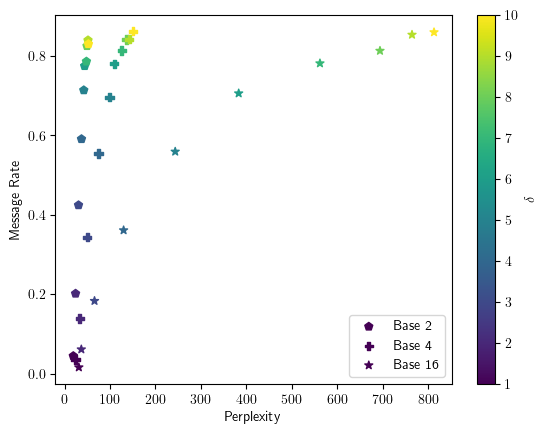

In [11]:
id = 0
for base in [2, 4, 16]:
    for num_beams in [1]:
        deltas = list(range(1, 11))
        msgs_rates = []
        ppls = []
        for delta in deltas:
            msg_rate, ppl = get_mean(results["delta_change"], {"base": base, "num_beams": num_beams, "delta": delta})
            msgs_rates.append(msg_rate)
            ppls.append(ppl)
        plt.scatter(ppls, msgs_rates, c=deltas, marker=markers[id], label=f"Base {base}")
        id += 1
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\delta$")
plt.xlabel("Perplexity")
plt.ylabel("Message Rate")
plt.legend()
plt.savefig("figs/delta_change/diff_base.pdf", bbox_inches="tight")

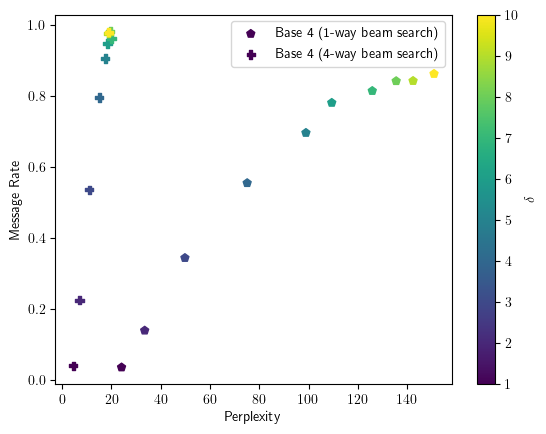

In [13]:
id = 0
for base in [4]:
    for num_beams in [1, 4]:
        deltas = list(range(1, 11))
        msgs_rates = []
        ppls = []
        for delta in deltas:
            msg_rate, ppl = get_mean(results["delta_change"], {"base": base, "num_beams": num_beams, "delta": delta})
            msgs_rates.append(msg_rate)
            ppls.append(ppl)
        plt.scatter(ppls, msgs_rates, c=deltas, marker=markers[id], label=f"Base {base} ({num_beams}-way beam search)")
        id += 1
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\delta$")
plt.xlabel("Perplexity")
plt.ylabel("Message Rate")
plt.legend()
plt.savefig("figs/delta_change/beam_search.pdf", bbox_inches="tight")

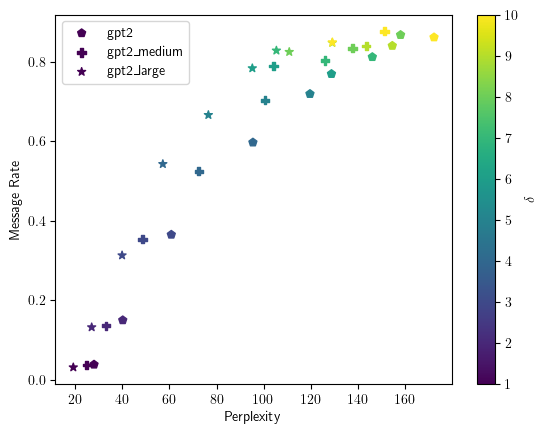

In [22]:
id = 0
for gen_model in ["gpt2", "gpt2_medium", "gpt2_large"]:
    for base in [4]:
        for num_beams in [1]:
            deltas = list(range(1, 11))
            msgs_rates = []
            ppls = []
            for delta in deltas:
                msg_rate, ppl = get_mean(results["delta_change"], {"base": base, "num_beams": num_beams, "delta": delta, "gen_model": gen_model})
                msgs_rates.append(msg_rate)
                ppls.append(ppl)
            plt.scatter(ppls, msgs_rates, c=deltas, marker=markers[id], label=f"{gen_model}")
            id += 1
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\delta$")
plt.xlabel("Perplexity")
plt.ylabel("Message Rate")
plt.legend()
plt.savefig("figs/llm/delta_change.pdf", bbox_inches="tight")

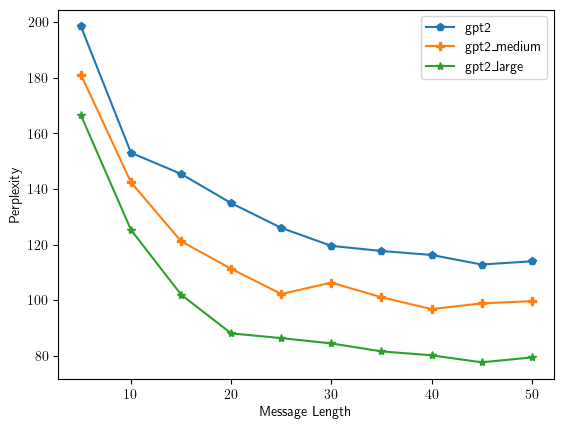

In [31]:
id = 0
for gen_model in ["gpt2", "gpt2_medium", "gpt2_large"]:
    for base in [4]:
        for num_beams in [1]:
            msgs_lens = list(range(5, 55, 5))
            msgs_rates = []
            ppls = []
            for msg_len in msgs_lens:
                msg_rate, ppl = get_mean(results["msg_len_change"], {"base": base, "num_beams": num_beams, "msg_len": msg_len, "gen_model": gen_model})
                msgs_rates.append(msg_rate)
                ppls.append(ppl)
            plt.plot(msgs_lens, ppls, marker=markers[id], label=f"{gen_model}")
            id += 1
plt.xlabel("Message Length")
plt.ylabel("Perplexity")
plt.legend()
plt.savefig("figs/llm/msg_len_change.pdf", bbox_inches="tight")

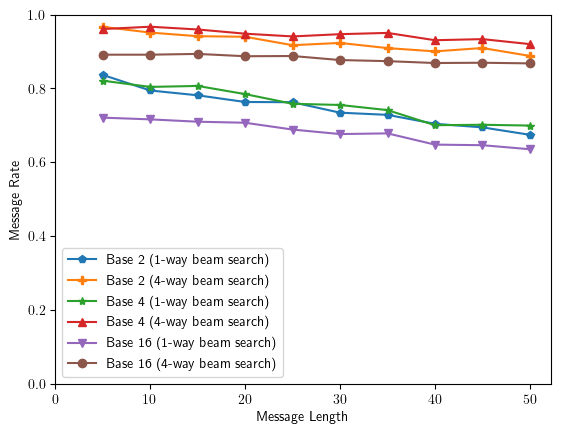

In [15]:
id = 0
for base in [2, 4, 16]:
    for num_beams in [1, 4]:
        msgs_lens = list(range(5, 55, 5))
        msgs_rates = []
        ppls = []
        for msg_len in msgs_lens:
            msg_rate, ppl = get_mean(results["msg_len_change"], {"base": base, "num_beams": num_beams, "msg_len": msg_len})
            msgs_rates.append(msg_rate)
            ppls.append(ppl)
        plt.plot(msgs_lens, msgs_rates, marker=markers[id], label=f"Base {base} ({num_beams}-way beam search)")
        id += 1
plt.xlim(xmin=0)
plt.ylim(ymin=0, ymax=1)
plt.xlabel("Message Length")
plt.ylabel("Message Rate")
plt.legend()
plt.savefig("figs/msg_len_change/msg_rate.pdf", bbox_inches="tight")

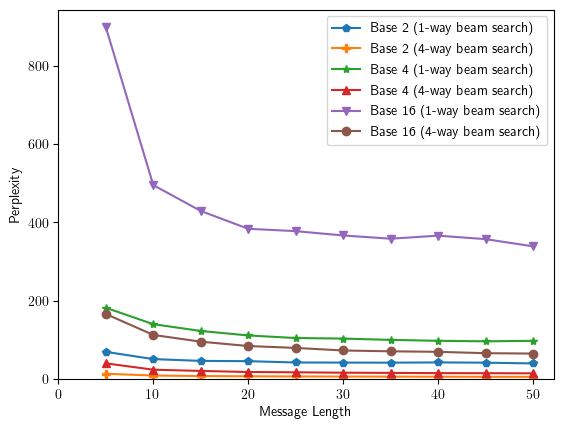

In [16]:
id = 0
for base in [2, 4, 16]:
    for num_beams in [1, 4]:
        msgs_lens = list(range(5, 55, 5))
        msgs_rates = []
        ppls = []
        for msg_len in msgs_lens:
            msg_rate, ppl = get_mean(results["msg_len_change"], {"base": base, "num_beams": num_beams, "msg_len": msg_len})
            msgs_rates.append(msg_rate)
            ppls.append(ppl)
        plt.plot(msgs_lens, ppls, marker=markers[id], label=f"Base {base} ({num_beams}-way beam search)")
        id += 1
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel("Message Length")
plt.ylabel("Perplexity")
plt.legend()
plt.savefig("figs/msg_len_change/perplexity.pdf", bbox_inches="tight")

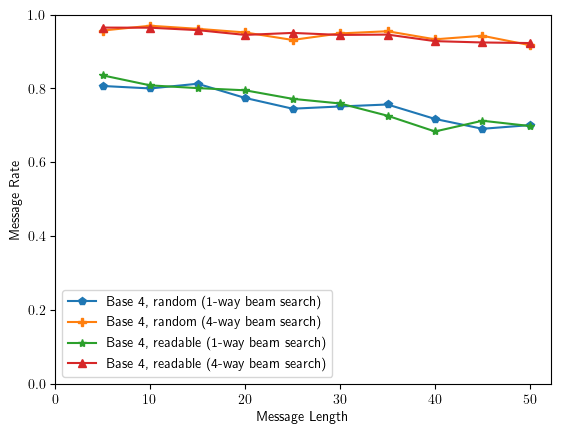

In [17]:
id = 0
for msg_type in ["random", "readable"]:
    for base in [4]:
        for num_beams in [1, 4]:
            msgs_lens = list(range(5, 55, 5))
            msgs_rates = []
            ppls = []
            for msg_len in msgs_lens:
                msg_rate, ppl = get_mean(results["msg_len_change"], {"base": base, "num_beams": num_beams, "msg_len": msg_len, "msg_type": msg_type})
                msgs_rates.append(msg_rate)
                ppls.append(ppl)
            plt.plot(msgs_lens, msgs_rates, marker=markers[id], label=f"Base {base}, {msg_type} ({num_beams}-way beam search)")
            id += 1
plt.xlim(xmin=0)
plt.ylim(ymin=0, ymax=1)
plt.xlabel("Message Length")
plt.ylabel("Message Rate")
plt.legend()
plt.savefig("figs/msg_type/msg_rate.pdf", bbox_inches="tight")

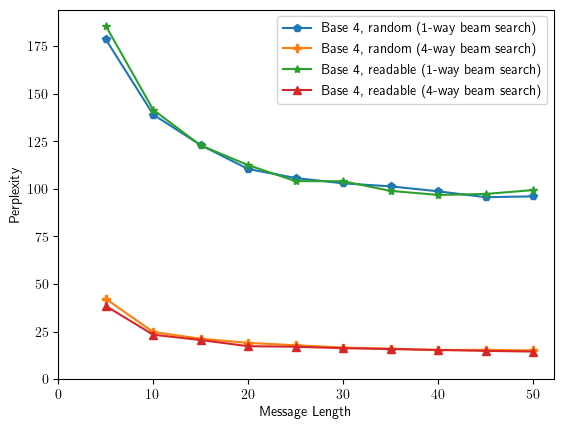

In [18]:
id = 0
for msg_type in ["random", "readable"]:
    for base in [4]:
        for num_beams in [1, 4]:
            msgs_lens = list(range(5, 55, 5))
            msgs_rates = []
            ppls = []
            for msg_len in msgs_lens:
                msg_rate, ppl = get_mean(results["msg_len_change"], {"base": base, "num_beams": num_beams, "msg_len": msg_len, "msg_type": msg_type})
                msgs_rates.append(msg_rate)
                ppls.append(ppl)
            plt.plot(msgs_lens, ppls, marker=markers[id], label=f"Base {base}, {msg_type} ({num_beams}-way beam search)")
            id += 1
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel("Message Length")
plt.ylabel("Perplexity")
plt.legend()
plt.savefig("figs/msg_type/perplexity.pdf", bbox_inches="tight")